In [25]:
import torch
from torch_geometric.data import Data
import numpy as np
import networkx as nx
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import matplotlib.pyplot as plt
import scipy.special as SS
import scipy.stats as SSA
import torch.nn.functional as F

In [21]:
# create a graph
A = np.array([[0.25 , 0.25, 0.4, 0.1 ],
        [0.25, 0.75 , 0. , 0. ],
        [0.4, 0. , 0.55 , 0.05],
        [0.1 , 0 , 0.05, 0.85 ]])

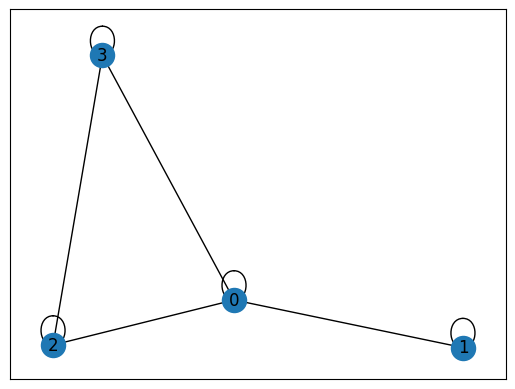

In [177]:
nx.draw_networkx(g, with_labels=True)

In [209]:
class SEIR_MPNN(MessagePassing):
    def __init__(self, params, pop, dt):
        super(SEIR_MPNN, self).__init__(aggr='add')
        self.R0 = params[0]
        self.Z = params[1]
        self.D = params[2]
        self.pop = torch.Tensor(pop)
        self.dt = dt
        
    def forward(self, x, edge_index, edge_attr, step):
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x, edge_attr=edge_attr, step=step)

    def message(self, x_j, edge_index, edge_attr, step):
#         print (x_j[:,1])
        
#         S, E, I, R = x_j.unbind(1)
        S, E, I, R = x_j[:, 0], x_j[:, 1], x_j[:, 2], x_j[:, 3]
        
        pop_edge_space = self.pop[edge_index[1]]
        
        ds = - self.R0 / self.D * S * I / pop_edge_space
        de = self.R0 / self.D * S * I / pop_edge_space - E/self.Z
        di = E/self.Z - I/self.D
        dr = I/self.D
        
        S = S + ds*self.dt
        E = E + de*self.dt
        I = I + di*self.dt
        R = R + dr*self.dt

        edge_weight_reshaped = edge_attr.view(-1)

        S *= edge_weight_reshaped
        E *= edge_weight_reshaped
        I *= edge_weight_reshaped
        R *= edge_weight_reshaped
        
        messages = torch.stack([S,E,I,R], dim=1)
        
        return messages

    def update(self, aggr_out, x, step):
#         print (aggr_out)
        x_new = aggr_out
        return x_new


In [219]:
def simulate_SEIR(R0=2.5, D=5, Z=3, adjacency_matrix=None, T=60):
    # Check if adjacency_matrix is provided

    # Define initial states for the nodes.
    N = adjacency_matrix.shape[0]
    x = torch.zeros(N, 4)
    x[:, 0] = 100
    x[2, 1] = 10
    x[2, 0] = 100-10

    # Get the indices where the adjacency matrix has a non-zero value
    edge_index = torch.nonzero(adjacency_matrix, as_tuple=False).t()

    # If your adjacency matrix has edge weights, you can get them like this:
    edge_weight = adjacency_matrix[edge_index[0], edge_index[1]]

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_weight)
    
    # Define your parameters and create a SEIR_MPNN instance
    params = [R0, Z, D]
    model = SEIR_MPNN(params, pop=torch.Tensor([100]*N), dt=1)
    
    pop = np.array([100]*4)
#     observations = np.zeros((4, T))
    observations = torch.zeros(4, T)
    observations[:, 0] = (R0/D*x[:, 0]*x[:, 2]/torch.Tensor(pop))


    for i in range(1, T):
        x = model(x, edge_index, data.edge_attr, i)
        observations[:, i] = (R0/D*x[:, 0]*x[:, 2]/torch.Tensor(pop))
    return observations

In [205]:
observations_t = simulate_SEIR(R0=torch.tensor(2.5), D=5, Z=3, adjacency_matrix=torch.tensor(A), T=60)
# print(observations_t)

In [188]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class EnhancedR0Predictor(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(EnhancedR0Predictor, self).__init__()
        self.seir_mpnn = SEIR_MPNN(params, pop, dt=1)  # Assuming params, pop, dt are defined
        self.conv1 = GCNConv(4, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, 1)

    def forward(self, x, edge_index, edge_attr, batch):
        # Process with SEIR_MPNN first
        x = self.seir_mpnn(x, edge_index, edge_attr, step)  # Assuming 'step' is known/defined

        # Then process with the GNN layers
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch)
        return self.lin(x)


In [190]:
def mse_loss(simulated, observed):
    return torch.mean((simulated - observed) ** 2)

In [228]:
# Assuming R0 is what you want to optimize
R0_infer = torch.tensor([2.0], requires_grad=True)

optimizer = torch.optim.SGD([R0_infer], lr=0.01)
num_epochs = 100
losses = []

for epoch in range(num_epochs):
    # Use your SEIR_MPNN model to simulate the spread
    simulated_output = simulate_SEIR(R0=R0_infer, D=5, Z=3, adjacency_matrix=torch.tensor(A), T=60)

    # Compute the loss
#     loss = mse_loss(simulated_output, observations)
    loss = mse_loss(torch.Tensor(simulated_output), torch.Tensor(observations))
#     print(simulated_output.requires_grad)
    
    # Backpropagation
    loss.backward()
    
    # Update the parameters
    optimizer.step()
    
    # Zero the gradients
    optimizer.zero_grad()
    
    losses.append(loss.item())

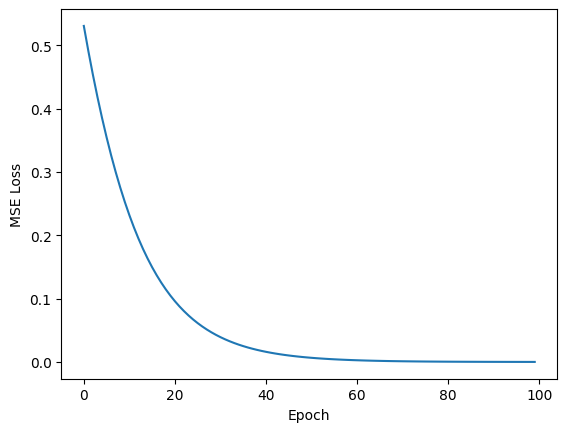

In [230]:
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

In [ ]:
beta = torch.nn.Parameter(torch.tensor(0.5))  # Initial beta
trained_beta = train(model, data, observed_data)
print(f"Inferred Beta: {trained_beta.item()}")
